# Learning Outcome
- IOU

## Extra (written on whiteboard)
1. Image Segmentation (performance measures)
    - Intersection Over Union (IOU)
2. Edge Detection
3. Contours
    - helps to isolate some regions of interest (ROI)
4. Contour Properties & Textures
    - helps to isolate some regions of interest (ROI)
5. Blob Detector (optional)

## Setup

In [1]:
!pip install requests

  Cache entry deserialization failed, entry ignored
You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## IOU
FORMULA:



In [3]:
def computeIOU(boxA, boxB):
    """boxA and boxB are of xyxy formats"""
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [6]:
img = cv.imread("lena.jfif")

In [7]:
boxes = cv.selectROIs("bounding box", img, showCrosshair=False)

cv.waitKey(0)
cv.destroyAllWindows()

In [8]:
boxes

array([[ 54,  42, 116, 137],
       [178,  38,  43,  49]])

In [9]:
def convert_xywh_to_xyxy(box):
    return[box[0], box[1], box[0] + box[2], box[1] + box[3]]

In [10]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy, (gt[0], gt[1]), (gt[2], gt[3]), (0, 0, 255), 2)
cv.rectangle(img_copy, (gt[0], gt[1]), (gt[2], gt[3]), (255, 0, 0), 2)
cv.putText(img_copy, f"IOU: {computeIOU(gt, pred):.3f}", (10, 25),
          cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

show_img("IOU", img_copy)

## Edge detection
Sobel x operator kernel formulation:

$$\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 &0 & 1 \end{bmatrix}$$

In [2]:
img = cv.imread("wood_planck.jfif", 0)

th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

show_img("binary", th)

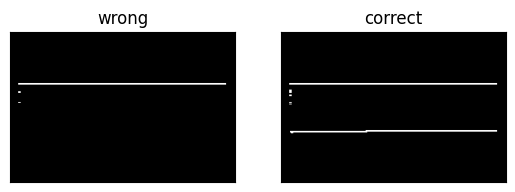

In [3]:
# sobel operators (can play around with x, y & operators type[ksize])

# wrong way
sobelx_8u = cv.Sobel(th, cv.CV_8U, 0, 1, ksize=-1)

# correct way
sobelx_32f = cv.Sobel(th, cv.CV_32F, 0, 1, ksize=-1)
sobelx = cv.convertScaleAbs(sobelx_32f) # absolute and convert to uint 8

plt.subplot(121), plt_img(sobelx_8u, "wrong")
plt.subplot(122), plt_img(sobelx, "correct")
plt.show()

### combine x and y edges
$$ \sqrt{Ix^2 + Iy^2} $$


Default: $$ |Ix| + |Iy| $$

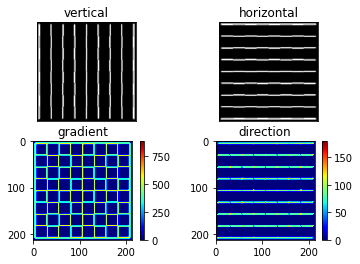

In [49]:
img = cv.imread("images/chessboard.png", 0)

# sobel x and y
sobelx_32f = cv.Sobel(img, cv.CV_32F, 1, 0)
sobelx = cv.convertScaleAbs(sobelx_32f)
sobely_32f = cv.Sobel(img, cv.CV_32F, 0, 1)
sobely = cv.convertScaleAbs(sobely_32f)

# gradient and direction
gradient = cv.magnitude(sobelx_32f, sobely_32f)
direction = cv.phase(sobelx_32f, sobely_32f, angleInDegrees=True) % 180

plt.subplot(221), plt_img(sobelx, "vertical")
plt.subplot(222), plt_img(sobely, "horizontal")
plt.subplot(223), plt.imshow(gradient, cmap="jet"), plt.title("gradient")
plt.colorbar()
plt.subplot(224), plt.imshow(direction, cmap="jet"), plt.title("direction")
plt.colorbar()
plt.show()

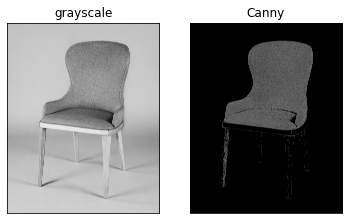

In [47]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 100, 300)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "Canny")

plt.show()

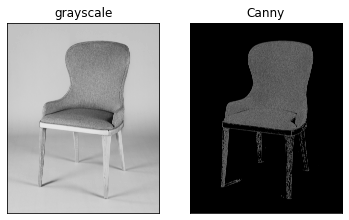

In [48]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 30, 150)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "Canny")

plt.show()

### Exercise
Create a trackbar that control the hysterisis thresholds and display the resulting images from the changes in the thresholds.

In [54]:
img = cv.imread("clock.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

ratio = 2.5
trackbar_name = "Th1"
wn = "Canny"
ksize = 3

def cannyThreshold(val):
    """Trackbar callback function"""
    edge = cv.Canny(gray, val, ratio*val, apertureSize=ksize)
    mask = edge != 0
    res = img * (mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    
cv.namedWindow(wn)
cv.createTrackbar(trackbar_name, wn, 10, 100, cannyThreshold)

cv.waitKey(0)
cv.destroyAllWindows()

In [64]:
def auto_canny(img, method, sigma=0.33):
    """Args:
    img: grayscale image
    method: median, otsu, triangle
    sigma:0.33 (default)"""
    if method == "median":
        Th = np.median(img)
        
    elif method == "otsu":
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
        
    elif method == "triangle":
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
        
    else:
        raise Exception("Method specified unavailable")
        
    lowTh = (1-sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img, lowTh, highTh)

### Contour detection

In [27]:
rect = np.zeros((256, 256), dtype=np.uint8)
cv.rectangle(rect, (25, 25), (231, 231), 255, -1)

show_img("rect", rect)

In [28]:
contours, _ = cv.findContours(rect, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

len(contours)

1

In [29]:
# points that encode the location of object
contours

(array([[[ 25,  25]],
 
        [[ 25, 231]],
 
        [[231, 231]],
 
        [[231,  25]]], dtype=int32),)

In [30]:
# load an image
img_bgr = cv.imread("monitor.jfif")
img = cv.imread("monitor.jfif", 0)

# threshold
th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

show_img("threshold", th)

contours, _ = cv.findContours(rect, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [31]:
len(contours)

1

In [32]:
cv.drawContours(img_bgr, contours, -1, (0, 255, 0), 1)

show_img("contours", img_bgr)

In [36]:
contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr_copy, contours, -1, (0, 255, 0), 1)

show_img("contours", img_bgr_copy)

In [127]:
len(contours)

12

In [34]:
contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [35]:
# contours with maximum number of points
length = [len(c) for c in contours]
contour_largest = contours[np.argmax(length)]

img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr_copy, [contour_largest], -1, (0, 255, 0), 1)

show_img("contours", img_bgr_copy)

In [130]:
print(cv.__version__)

4.6.0


In [131]:
cnt = contour_largest

## Contour features

In [132]:
# only make use of first 3
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [133]:
# centroid (center of mass)
cx = int(M["m10"] / M["m00"])
cy = int(M["m01"] / M["m00"])

print(f"the centroid of monitor: {(cx, cy)}")

the centroid of monitor: (105, 103)


In [134]:
#area and perimeter
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt, True)

print(f"The area of monitor: {area}")
print(f"The perimeter of monitor: {peri:.3f}")

The area of monitor: 37113.5
The perimeter of monitor: 1056.777


In [37]:
img = cv.imread("remote-controller.webp")

show_img("img", img)

In [47]:
# resize -> grayscale -> bilateral filter -> edge detection -> find contour -> contour features
factor = 300 / img.shape[1]
img = cv.resize(img, None, fx=factor, fy=factor)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = auto_canny(blur, method="triangle")

show_img("edge", edge)

NameError: name 'auto_canny' is not defined

In [46]:
# find contour
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# area
contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]
screen = None
img_copy = img.copy()

for c in contours:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)
    
    if len(approx)==4:
        screen = c
        break
        
cv.drawContours(img_copy, [screen], -1, (255, 0, 255), 2)
show_img("screen", img_copy)

NameError: name 'edge' is not defined

Circularity:

$$circularity = \frac{4 \times \pi \times Area}{Perimeter^2}$$

### Demo on red object detector

In [55]:
redLow1 = (0, 90, 40)
redHigh1 = (10, 255, 210)

redLow2 = (170, 90, 40)
redHigh2 = (179, 255, 210)

cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit("No webcam detected")
    
#factor
fixed_width = min_area = 500
factor = fixed_width / cap.get(3) #frame width
kernel = np.ones((3, 3), dtype=np.uint8)

while(1):
    ret, frame = cap.read()
    
    if not ret:
        print("No frame received")
        break
        
    #resize, blur, change to hsv, inRange, mask integration, morphological operation, find contour, bounding box
    resized = cv.resize(frame, None, fx=factor, fy=factor)
    blur = cv.GaussianBlur(resized, (5, 5), 0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    
    mask1 = cv.inRange(img_hsv, redLow1, redHigh1)
    mask2 = cv.inRange(img_hsv, redLow2, redHigh2)
    mask = cv.add(mask1, mask2)
    # suppress noise
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=2)
    
    #find contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    bbs = []
    centroids = []
    
    for c in contours:
        area = cv.contourArea(c)
        if area > min_area:
            bb = cv.boundingRect(c)
            M = cv.moments(c)
            cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
            centroids.append((cx, cy))
            bbs.append(bb)
            
    for bb, centroid in zip(bbs, centroids):
        x, y, w, h = bb
        cv.rectangle(resized, (x, y), (x+w, y+h), (255, 255, 0), 2)
        cv.circle(resized, centroids, 2, (255, 0, 0), -1)
    
    cv.imshow("red object", resized)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()
cap.release()

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Expected sequence length 2, got 1
>  - Can't parse 'center'. Expected sequence length 2, got 1


## Weekly Exercise

### Question 1
Experiment with different edge detectors: Sobel, Laplacian, Prewitt, Scharr derivatives and Canny operators (all with aperture size of 3) on image named 'pineapple.jfif'. Comment on the results.

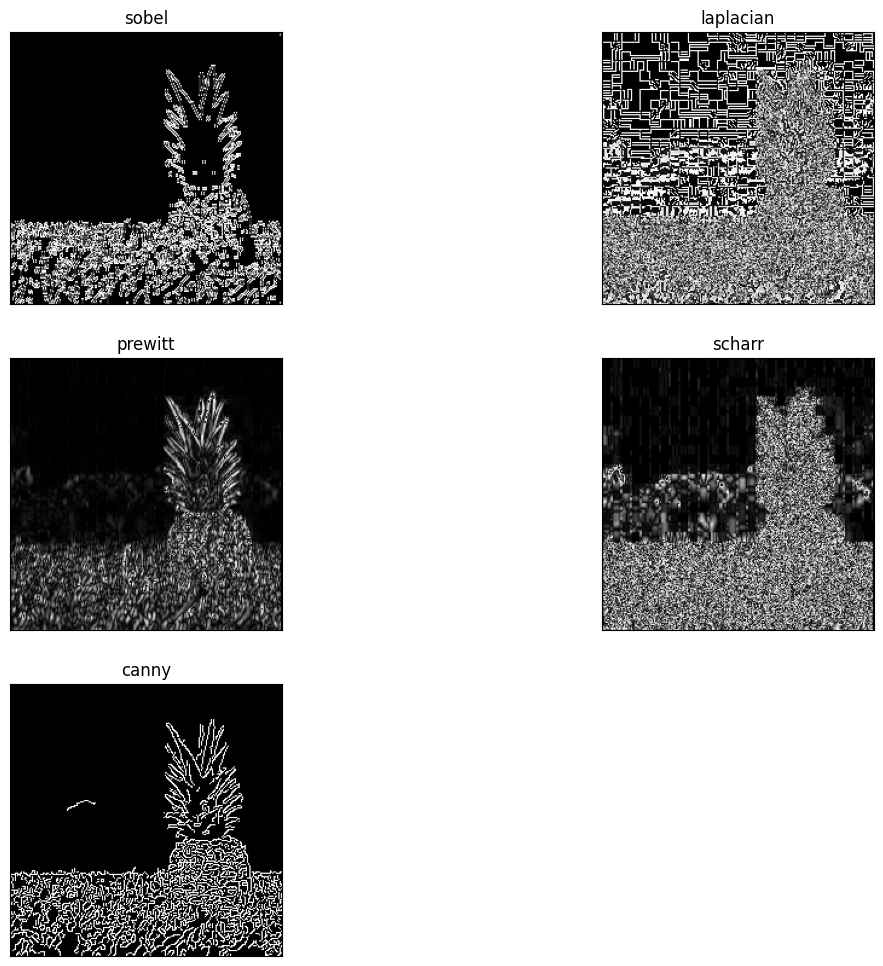

In [105]:
##### img = cv.imread("pineapple.jfif", 0)
# Sobel
#th = cv.threshold(img, 130, 200, cv.THRESH_BINARY_INV)[1]
sobelx = cv.Sobel(th, cv.CV_32F, 1, 0, ksize=3)
sobely = cv.Sobel(th, cv.CV_32F, 0, 1, ksize=3)
sobel = np.sqrt(sobelx ** 2, sobely ** 2).astype(np.uint8)

# Laplacian
laplacian = (cv.Laplacian(img, cv.CV_32F,ksize=3)).astype(np.uint8)

# Prewitt
x = np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]])
y = np.array([[-1, -1, -1],[0, 0, 0],[1, 1, 1]])
gradientx = cv.filter2D(img, cv.CV_32F, x)
gradienty = cv.filter2D(img, cv.CV_32F, y)
prewitt = np.sqrt(gradientx ** 2, gradienty ** 2).astype(np.uint8)

# Scharr
x = cv.Scharr(img, cv.CV_32F, 1, 0)
y = cv.Scharr(img, cv.CV_32F, 0, 1)
scharr = np.sqrt(x ** 2, y ** 2).astype(np.uint8)

# Canny
canny = cv.Canny(img, 100, 200)

plt.figure(figsize=(14, 12))
plt.subplot(321), plt_img(sobel, "sobel")
plt.subplot(322), plt_img(laplacian, "laplacian")
plt.subplot(323), plt_img(prewitt, "prewitt")
plt.subplot(324), plt_img(scharr, "scharr")
plt.subplot(325), plt_img(canny, "canny")

plt.show()

# comments
# sobel: unclear edges, pineapple edge is blended with the surrounding, very blurry
# laplacian: the worst among all the other edge detection, a lot of noises
# prewitt: the edges of the pineapple are sharper, able to differentiate it with the surrounding
# scharr: the edges of pineapple in the grass background is totally gone
# canny: overall edges are super sharp, but the pineapple edges in the grass background becomes 50% 50% in terms of visibility

### Question 2
Write a program to identify the white object (probably laptop) present in the image 'electronic.jfif'. Draw bounding boxes on the objects.

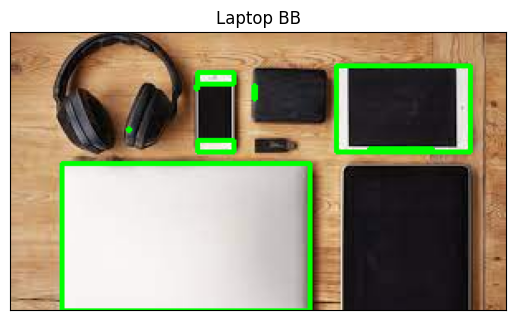

In [79]:
img = cv.imread("electronic.jfif")
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
blur = cv.GaussianBlur(img_hsv, (3, 3), 0)
kernel = np.ones((3, 3), dtype=np.uint8)

whiteLow = (0, 0, 111)
whiteHigh = (49, 41, 255)

bbs = []

mask1 = cv.inRange(blur, whiteLow, whiteHigh)
contours, _ = cv.findContours(mask1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

for c in contours:
        bb = cv.boundingRect(c)
        bbs.append(bb)
        
for bb in bbs:
    x, y, w, h = bb
    cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt_img(img, "Laptop BB")
plt.show()


### Question 3
Isolate the clock with the aid of edge detection and contours' properties. The example result should be as follows:

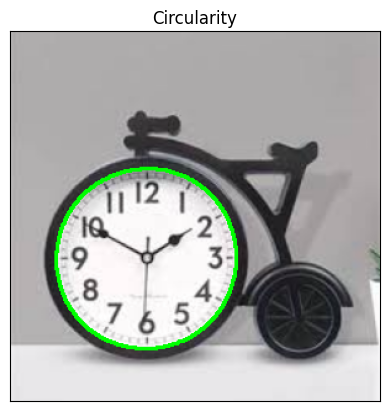

In [75]:
img = cv.imread("clock.jpg")
factor = 300 / img.shape[1]
img = cv.resize(img, None, fx=factor, fy=factor)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = auto_canny(blur, method="triangle")

# find contour
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# area
contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]
screen = None
img_copy = img.copy()

for c in contours:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)
    
    if len(approx)==4:
        screen = c
        break
        
cv.drawContours(img_copy, [screen], -1, (0, 255, 0), 2)

plt_img(img_copy, "Circularity")
plt.show()